# Lab 2, Training

In [126]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffuse.diffusion_utilities import *
from diffuse.models.context_unet import ContextUnet
import os
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from diffuse.noise_scheduler import NoiseScheduler
from diffuse.utils import pil_image_grid
from PIL import Image
from einops import rearrange


# Setting Things Up

In [127]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [128]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [129]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Training

In [130]:
# load dataset and construct optimizer
dataset = CustomDataset("../data/sprites_1788_16x16.npy", "../data/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [131]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [132]:
# training without context code

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:17<00:00, 51.20it/s]


saved model at ./weights/model_0.pth
epoch 1


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 605/894 [00:13<00:06, 45.62it/s]


KeyboardInterrupt: 

# Sampling

In [ ]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [219]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=32):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#### View Epoch 0 

In [ ]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

In [182]:
samples, intermediate_ddpm = sample_ddpm(32,save_rate=12)

In [183]:
from diffuse.diffusion_utilities import unorm, norm_torch


In [206]:
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z_normed = unorm(z)
pils = [[ToPILImage()(z__) for z__ in z_] for z_ in z_normed]
pil_image_grid(pils[3], 10,(100,100))

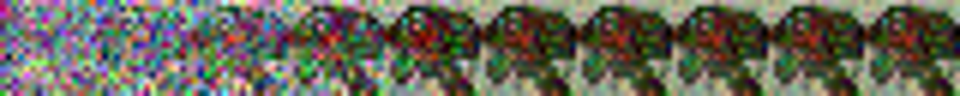

In [217]:
z[0][-1].max()

1.4990017

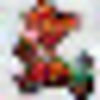

In [214]:
ToPILImage()(unorm(z[0][-1])).resize((100,100))

In [205]:
np.array(pils[3][-1]).min(), np.array(pils[3][-1]).max()

(0, 205)

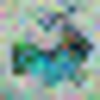

In [203]:
pils[][-1].resize((100,100))

In [190]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32, 100)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())


<Figure size 640x480 with 0 Axes>

In [191]:
HTML(animation_ddpm.to_jshtml())

#### View Epoch 4 

In [73]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


In [74]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())


KeyboardInterrupt



<Figure size 640x480 with 0 Axes>

#### View Epoch 8

In [ ]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_8.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

In [ ]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

#### View Epoch 31 

In [221]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_31.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


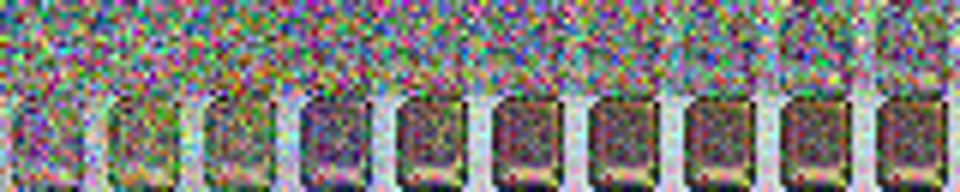

In [248]:
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
# z_normed = unorm(z)
pils = [[ToPILImage()(unorm(z__)) for z__ in z_] for z_ in z_normed]
pil_image_grid(pils[3], 10,(100,100))

In [252]:
len(pils[-1])

23

In [235]:
!which python

/mnt/ssd3/user/spock/.cache/pypoetry/virtualenvs/diffuse-yAF6RCIf-py3.11/bin/python


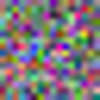

In [247]:
pils[-1][-].resize((100,100))

In [253]:
# def plot_sample(x_gen_store, n_sample, nrows, save_dir, fn, w, save=False):
x_gen_store=intermediate_ddpm
n_sample=32
nrow=4
ncols = n_sample // nrows
sx_gen_store = np.moveaxis(x_gen_store, 2, 4)  # change to Numpy image format (h,w,channels) vs (channels,h,w)
nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0],
                         n_sample)  # unity norm to put in range [0,1] for np.imshow


In [255]:
nsx_gen_store.shape

(23, 32, 16, 16, 3)

In [222]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

# Acknowledgments
Sprites by ElvGames, [FrootsnVeggies](https://zrghr.itch.io/froots-and-veggies-culinary-pixels) and  [kyrise](https://kyrise.itch.io/)   
This code is modified from, https://github.com/cloneofsimo/minDiffusion   
Diffusion model is based on [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) and [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502)
